<h1>Desafio

In [22]:
#Importando biblioteca
import pandas as pd

In [23]:
#Carregando os dados
transactional = pd.read_csv('transactional_data.csv', sep=';')
test = pd.read_csv('test_data.csv', sep=',')
geo = pd.read_csv('df_geocode.csv', sep=',')
economic = pd.read_csv('EconomicData_ZCTAs.csv', sep=',')
demographic = pd.read_csv('DemographicData_ZCTAs.csv', sep=',')

<h1>Tratamento de dados

In [24]:
#transactional.info() 
transactional.dropna(inplace=True) #Removendo dados vazios
transactional.drop_duplicates(inplace=True) #Removendo dados duplicados
#transactional
transactional["Date of birth"] = pd.to_datetime(transactional["Date of birth"]) #Transformando em data
transactional["Date of service"] = pd.to_datetime(transactional["Date of service"]) #Transformando em data
transactional['Gender'] = transactional['Gender'].astype('string') #Tranformando em string
transactional['Testing Cost'] = transactional['Testing Cost'].str.replace(',','.').astype(float) #Tranformando em float
#transactional.info()

#test.info()
test.dropna(inplace=True)
test.drop_duplicates(inplace=True)
#test

#geo.info()
geo.dropna(inplace=True)
geo.drop(['Unnamed: 0'],axis=1,inplace=True)
geo.drop_duplicates(inplace=True)
geo['Zipcode'] = geo['Zipcode'].astype(int)
#geo

#Separando latitude e longitude da coluna location
latitude = []
longitude = []
for i in geo['Location']:
    ll = i.split(",")
    latitude.append(ll[0])
    longitude.append(ll[1])
geo['LAT']=latitude
geo['LON']= longitude
geo['LAT'] = geo['LAT'].astype(float)
geo['LON'] = geo['LON'].astype(float)

#economic.info()
economic.dropna(inplace=True)
economic.drop(['Unnamed: 0'],axis=1,inplace=True)
economic.drop_duplicates(inplace=True)
#economic

#demographic.info()
demographic.dropna(inplace=True)
demographic.drop(['Unnamed: 0'],axis=1,inplace=True)
demographic.drop_duplicates(inplace=True)
#demographic

#Percebi que os numeros finais da coluna ID era o zipcode então resolvi separar para mesclar tabelas que tinha zipcode em comum
Zipcode = []
Zipcode1 = []

for i in economic['id']:
    zip = i[9:]
    Zipcode.append(zip)
for i in demographic['Id']:
    zip = i[9:]
    Zipcode1.append(zip)
    
    
economic.dropna(inplace=True)
economic['Zipcode'] = Zipcode
#economic
demographic['Zipcode'] = Zipcode1
demographic.dropna(inplace=True)
#demographic

demographic['Zipcode'] = demographic['Zipcode'].astype(int)
economic['Zipcode'] = economic['Zipcode'].astype(int)

#Mesclando tabelas com dados em comum para facilitar
filtrado_test =test[['CodItem','Desc Item','Testing Cost']]
filtrado_geo = geo[['Lab Id','Location', 'Zipcode']]
mesclado_transactional = transactional.merge(filtrado_test, on='CodItem').merge(filtrado_geo, on='Lab Id')
#mesclado_transactional
mesclado_eco_demo = economic.merge(demographic, on='Zipcode')
#mesclado_eco_demo

<h1>O que os dados dizem?

In [25]:
#Quais lugares não tem labs?
falta_lab = pd.merge(geo, mesclado_eco_demo, on=['Zipcode','Zipcode'], how="outer", indicator=True)
falta_lab = falta_lab[falta_lab['_merge'] == 'right_only']
falta_lab.drop(['_merge'],axis=1,inplace=True)
falta_lab.dropna(axis=1,inplace=True)
#falta_lab

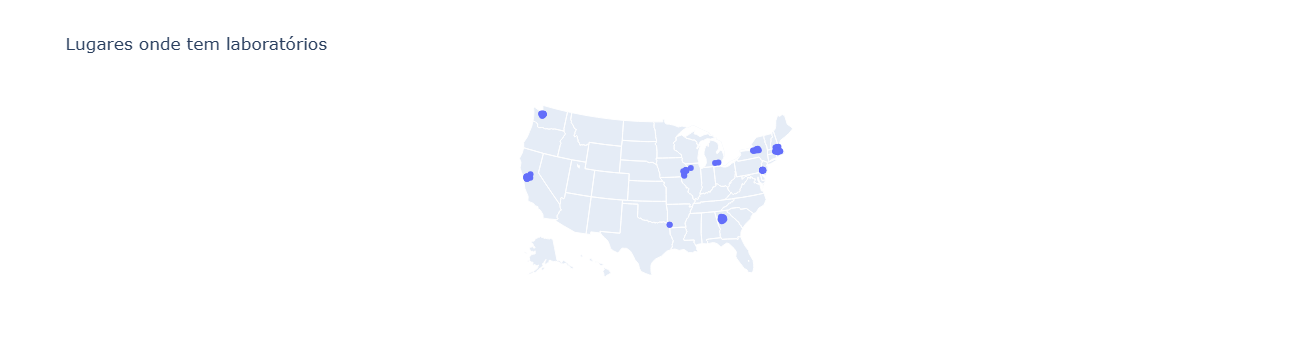

In [26]:
#Lucro de onde tem lab e localização para plotar gráfico
lucro_onde_tem=mesclado_transactional
lucro_onde_tem['lucro'] = lucro_onde_tem['Testing Cost_x'] - lucro_onde_tem['Testing Cost_y']
lucro_onde_tem = lucro_onde_tem.groupby(['Lab Id', 'Zipcode']).agg(lucro_sum=('lucro', 'sum')).reset_index()
lucro_onde_tem_loc = pd.merge(lucro_onde_tem, geo[['Lab Id', 'LAT', 'LON']], how='right', on=['Lab Id'])

#Lucro_onde_tem_loc

import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = lucro_onde_tem_loc['LON'],
        lat = lucro_onde_tem_loc['LAT'],
        mode = 'markers',
            ))
fig.update_layout(title_text='Lugares onde tem laboratórios')
fig.update_layout(
        geo_scope='usa',
    )
fig.show()

In [27]:
#Juntar lucro com tabela mesclada(será usado como dados de teste na regressão logistica para tentar prever lucro)
filtrada_lucro = pd.merge(lucro_onde_tem, mesclado_eco_demo, on=['Zipcode','Zipcode'], how="inner", indicator=True)
#Apagando variáveis que não preciso
filtrada_lucro.drop(['_merge','Lab Id','Zipcode','id','Geographic Area Name','Id', 'GeographicAreaName'],axis=1,inplace=True)
#filtrada_lucro

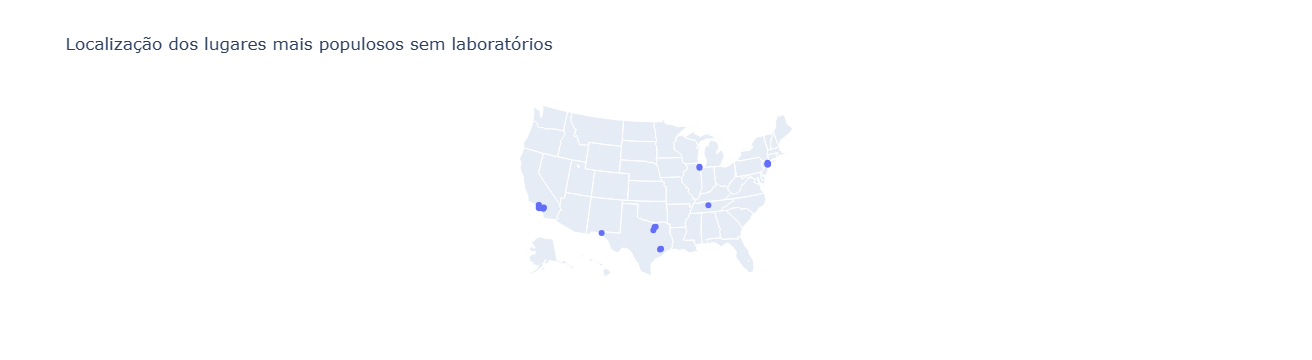

In [28]:
#30 cidades mais populosas onde não tem(possíveis novos laboratórios)
mais_pop=falta_lab.sort_values(by='TotalPopulation', ascending=False).head(30)
mais_pop.drop(['id','Geographic Area Name','Id', 'GeographicAreaName'],axis=1,inplace=True)
#mais_pop

#Buscando zipcode para plotar gráfico de cidades mais populosas que faltam
import os
import pgeocode

#Primeiro transformando em lista
postal_codes = mais_pop['Zipcode'].values.astype('str').tolist()

#Códigos postais por iso
nomi = pgeocode.Nominatim('us')

#Buscando códigos postais
us_post = nomi.query_postal_code(postal_codes)

#Removendo colunas que não preciso
us_post.drop(['community_name','community_code'], axis=1, inplace=True)
us_post.dropna(inplace=True)

#Transformando em valor inteiro para mesclar o que as tabelas tem em comum
us_post['postal_code'] = us_post['postal_code'].astype(int)
mais_pop_loc = pd.merge(mais_pop, us_post[['postal_code', 'latitude', 'longitude']], how='right', left_on=['Zipcode'], right_on=['postal_code'])
#mais_pop_loc

#Gráfico com as 30 cidades mais populosas que não tem laboratórios da rede
fig1 = go.Figure(data=go.Scattergeo(
        lon = mais_pop_loc['longitude'],
        lat = mais_pop_loc['latitude'],
        mode = 'markers',
            ))
fig1.update_layout(title_text='Localização dos lugares mais populosos sem laboratórios')
fig1.update_layout(
        geo_scope='usa',
    )
fig1.show()

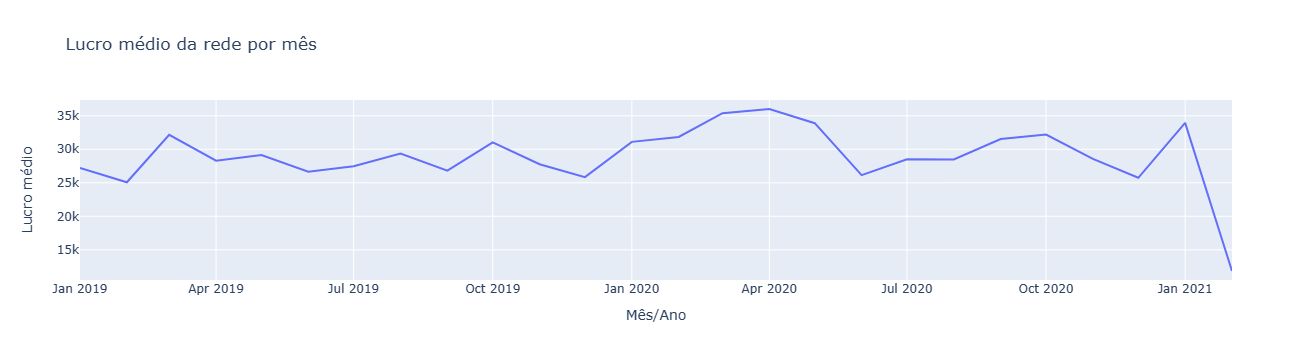

In [43]:
#Lucro por mês e ano
lucro_por=mesclado_transactional[['Lab Id', 'Date of service','Testing Cost_x','Testing Cost_y']].copy()
lucro_por['lucro']=lucro_por['Testing Cost_x'] - lucro_por['Testing Cost_y']
#lucro_por


lucro_data_por_lab = lucro_por.groupby(['Lab Id', 'Date of service']).agg(lucro_sum=('lucro', 'sum')).reset_index()
#Lambda para transformar datetime em mês e ano
lucro_data_por_lab['Date of service']=lucro_data_por_lab['Date of service'].apply(lambda x: x.__format__('%Y-%m'))
lucro_data = lucro_data_por_lab.groupby(['Date of service']).agg(lucro_sum_sum=('lucro_sum', 'sum')).reset_index()

#Lucro por mes cada lab
lucro_data_por_lab = lucro_data_por_lab.groupby(['Lab Id', 'Date of service']).agg(lucro_sum_sum=('lucro_sum', 'sum')).reset_index()
#Média lucro por mes
lucro_data_por_lab = lucro_data_por_lab.groupby(['Date of service']).agg(lucro_sum_sum_mean=('lucro_sum_sum', 'mean')).reset_index()

import plotly.express as px
fig2 = px.line(lucro_data_por_lab.sort_values(by=['Date of service'], ascending=[True]), x='Date of service', y='lucro_sum_sum_mean', title='Lucro médio da rede por mês')
fig2.update_xaxes(title_text='Mês/Ano')
fig2.update_yaxes(title_text='Lucro médio')
fig2

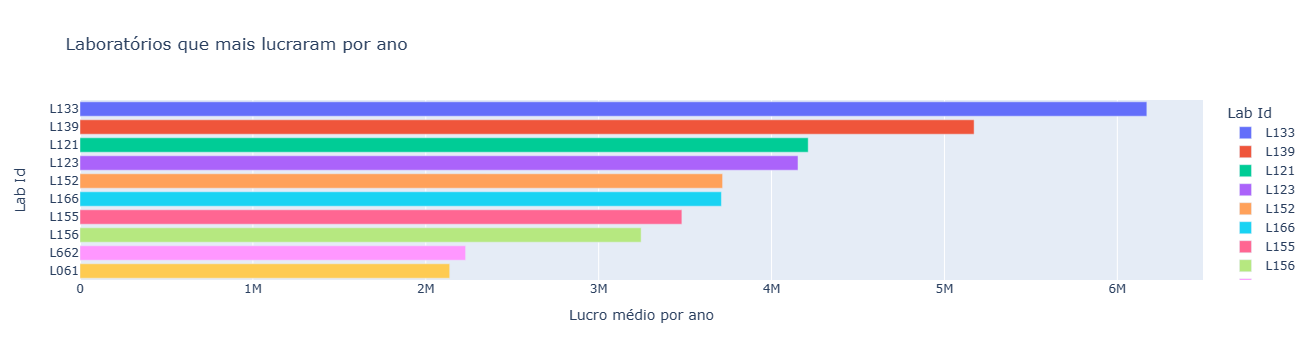

In [30]:
#Lucro médio mais alto por lab
lucro_alto = lucro_por.groupby(['Lab Id', 'Date of service']).agg(lucro_sum=('lucro', 'sum')).reset_index()
#Lambda para transformar datetime em somente ano
lucro_alto['Date of service']=lucro_alto['Date of service'].apply(lambda x: x.__format__('%Y'))
lucro_alto = lucro_alto.groupby(['Lab Id', 'Date of service']).agg(lucro_sum_sum=('lucro_sum', 'sum')).reset_index()
lucro_alto = lucro_alto.groupby(['Lab Id']).agg(lucro_sum_sum_sum=('lucro_sum_sum', 'sum')).reset_index()
lucro_alto = lucro_alto.sort_values(by=['lucro_sum_sum_sum'], ascending=[False]).head(10)

fig3 = px.bar(lucro_alto, x='lucro_sum_sum_sum', y='Lab Id', title='Laboratórios que mais lucraram por ano', color='Lab Id')
fig3.update_xaxes(title_text='Lucro médio por ano')
fig3

<h1>O que eu posso prever?

In [31]:
#Procurando o mínimo , a mediana e o máximo para os dados de previsão

#filtrada_lucro['lucro_sum'].min()
#filtrada_lucro['lucro_sum'].median()
#filtrada_lucro['lucro_sum'].max()

classe1=[]
for i in filtrada_lucro['lucro_sum']:
    if i >= 1819.15 and i <= 326370.0:
        classe1.append(0)
    else:
        classe1.append(1) 
filtrada_lucro['classe'] = classe1
#filtrada_lucro

<h2> Algoritmo SVM para classificar se os lugares que não tem laboratórios seriam bons lugares para receber os laboratórios

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import stats
from sklearn.svm import SVC

previsores=filtrada_lucro.iloc[:,1:27].values
classe=filtrada_lucro['classe'].values

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores,
                                                                  classe,
                                                                  test_size = 0.3,
                                                                  random_state = 0)

svm = SVC()
svm.fit(X_treinamento, y_treinamento)

previsaoSvm = svm.predict(X_teste)

#confusion_matrix(y_teste, svm.predict(X_teste))

acertoSvm = accuracy_score(y_teste, svm.predict(X_teste))
#acertoSvm*100

<h2> Algoritmo com taxa de acerto de 91% previu que todas lugares seriam bons

In [33]:
#Prevendo nas cidades mais populosas que faltam lab
achar=mais_pop.iloc[:,1:27].values
#svm.predict(achar)

<h2>Vamos prever o lucro esperado desses lugares de acordo com os dados de renda, população e idade

In [34]:
from sklearn.linear_model import LinearRegression

X_treino, X_test, y_treino, y_test = train_test_split(filtrada_lucro.iloc[:,1:27].values,
                                                      filtrada_lucro.iloc[:,0].values,
                                                      test_size = 0.3,
                                                      random_state = 0)
modelo = LinearRegression()
modelo.fit(X_treino, y_treino)
lucro_esperado=modelo.predict(achar)
lucro_esperado=lucro_esperado.tolist()
#lucro_esperado[:15]

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_8556\930101939.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



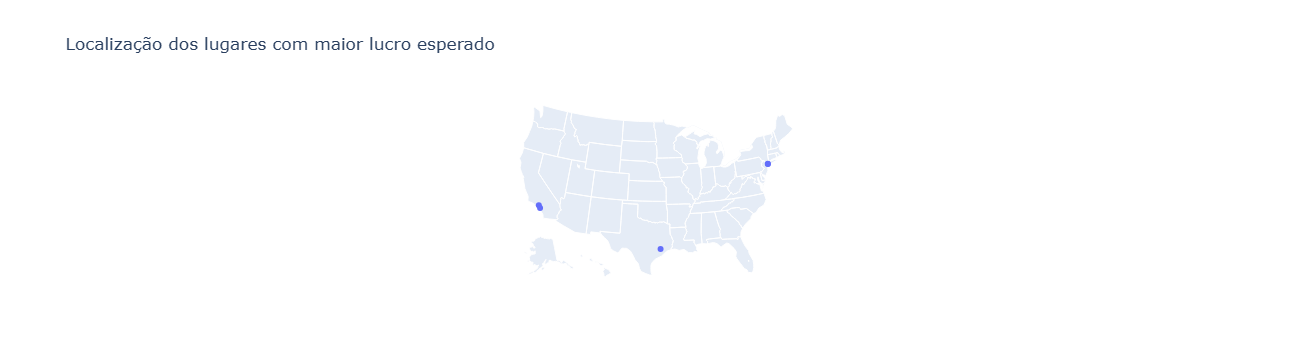

In [35]:
#Agora vamos ver o top 5 do esperado das 15 cidades mais populosas que faltam
top_5 = mais_pop_loc[:15]
top_5['lucro_esperado'] = lucro_esperado[:15]
top_5 = top_5.sort_values(by='lucro_esperado', ascending=False).head()
top_5= top_5[['Zipcode','latitude','longitude','lucro_esperado']]
top_5

#Gráfico locais
fig4 = go.Figure(data=go.Scattergeo(
        lon = top_5['longitude'],
        lat = top_5['latitude'],
        mode = 'markers',
            ))
fig4.update_layout(title_text='Localização dos lugares com maior lucro esperado')
fig4.update_layout(
        geo_scope='usa',
    )
fig4.show()

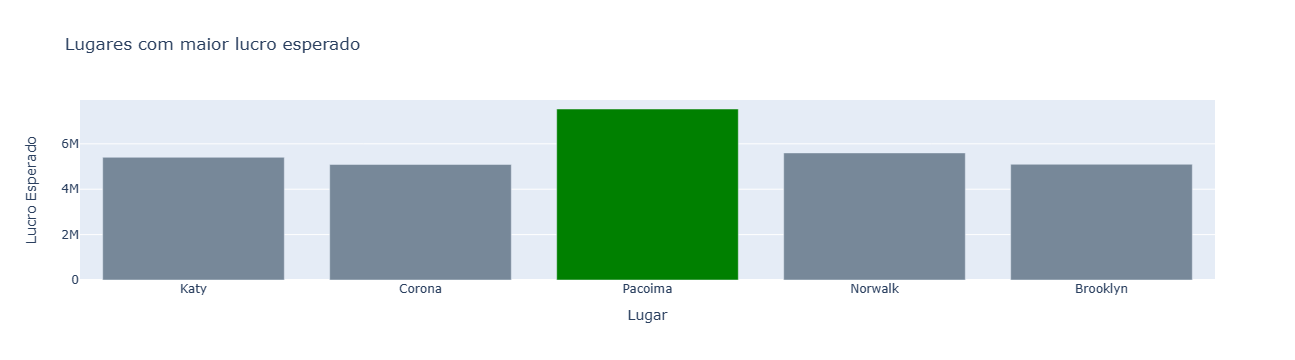

In [36]:
#Gráfico de barras top 5

top_5_nomes = pd.merge(top_5, us_post[['postal_code', 'place_name']], how='right', left_on=['Zipcode'], right_on=['postal_code'])
top_5_nomes = top_5_nomes.dropna()
top_5_nomes = top_5_nomes.drop(columns=['postal_code', 'Zipcode', 'latitude', 'longitude'])

top_5_nomes

colors = ['lightslategray'] * 5
colors[2] = 'green'
fig5=go.Figure(data=[go.Bar(
    x=top_5_nomes['place_name'],
    y=top_5_nomes['lucro_esperado'],
    marker_color=colors
)])
fig5.update_layout(title_text='Lugares com maior lucro esperado')
fig5.update_xaxes(title_text='Lugar')
fig5.update_yaxes(title_text='Lucro Esperado')
fig5

<h1> Com a ajuda da IA definimos que o melhor lugar para um novo laboratório rede seria Pacoima